<a href="https://colab.research.google.com/github/Kevin00404/TA047R-2C2024-GRUPO09/blob/main/TA047R_TP1_GRUPO09_ENTREGA_EJ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Introducción***

***Ejercicio 2: Modelos de Clasificación Binaria***

En este ejercicio, utilizaremos datos de estaciones meteorológicas de Australia para predecir si lloverá al día siguiente, a través de la variable RainTomorrow.

***Casos de Estudio***

Nuestros casos de estudio son Nueva Gales del Sur y Victoria.

***Objetivos:***

* Analizar la variabilidad de los datos.
* Aplicar modelos de clasificación.
* Evaluar y comparar la efectividad de los modelos en las predicciones.

Este ejercicio nos permitirá entender mejor cómo los modelos de clasificación pueden utilizarse en la predicción de eventos climáticos.


## Análisis Exploratorio y preprocesamiento de datos

### Importación de librerías que vamos a usar

In [ ]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

In [ ]:
#Visualización
!pip install plotly_express
!pip install 'dtreeviz'

import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt
import dtreeviz

In [ ]:
# Modelos y métricas
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    recall_score,
    accuracy_score,
    f1_score,
    precision_score
)

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path = "/content/drive/MyDrive/TP Ciencia de Datos G9/Datasets/weatherAUS.csv"


In [ ]:
#Archivo tiene que estar previamente cargado al entorno de
df = pd.read_csv("weatherAUS.csv")
df_shape_pre_limpieza = df.shape[0]

### Métodos globales

In [ ]:
def mostrar_info_columna(df, columna):
    """
    Muestra información sobre una columna específica del DataFrame.

    :param df: DataFrame de pandas
    :param columna: Nombre de la columna a analizar
    """
    print(f"# Información de la columna '{columna}'")
    print("-" * 40)

    # Contando valores únicos y nulos
    n_total = len(df)  # Total de valores
    n_non_null = df[columna].count()  # Total de valores no nulos
    n_unique = df[columna].nunique()  # Número de valores únicos
    n_null = df[columna].isnull().sum()  # Número de valores nulos
    dtype = df[columna].dtype  # Tipo de datos

    # Calculando el porcentaje de nulos
    percentage_null = (n_null / n_total) * 100 if n_total > 0 else 0

    # Formateando la salida
    print(f"Total de entradas: {n_total}")
    print(f"Valores no nulos: {n_non_null}")
    print(f"Valores únicos: {n_unique}")
    print(f"Valores nulos: {n_null}")
    print(f"Porcentaje de valores nulos/total de entradas: {percentage_null:.2f}%")
    print(f"Tipo de datos: {dtype}")

In [ ]:
def chequear_valores_negativos(df, columna):
    """
    Chequea y muestra información sobre valores negativos en una columna específica del DataFrame.

    :param df: DataFrame de pandas
    :param columna: Nombre de la columna a analizar
    """
    # Filtrar los valores negativos
    negativos = df[df[columna] < 0]

    # Calcular el porcentaje de valores negativos sobre el total de filas
    total_filas = df.shape[0]
    porcentaje_negativos = (negativos.shape[0] / total_filas) * 100 if total_filas > 0 else 0

    # Mostrar los resultados
    if not negativos.empty:
        print(f"Se encontaron valores negativos encontrados en '{columna}'.")
        print(f"Porcentaje de valores negativos sobre el total de filas: {porcentaje_negativos:.2f}%")
    else:
        print(f"No se encontraron valores negativos en '{columna}'.")

In [ ]:
def asignar_estacion(fecha):
    """
    Asigna la estación del año según la fecha dada.

    Parámetros:
    fecha (datetime): Un objeto datetime que representa la fecha a evaluar.

    Retorna:
    str: La estación correspondiente a la fecha:
        - 'Verano' para el 1 de diciembre hasta el 28/29 de febrero
        - 'Otoño' para el 1 de marzo hasta el 31 de mayo
        - 'Invierno' para el 1 de junio hasta el 31 de agosto
        - 'Primavera' para el 1 de septiembre hasta el 30 de noviembre
    """
    if (fecha.month == 12 and fecha.day >= 1) or (fecha.month == 1) or (fecha.month == 2) or (fecha.month == 3 and fecha.day < 1):
        return 'Summer'
    elif (fecha.month == 3) or (fecha.month in [4, 5]) or (fecha.month == 6 and fecha.day < 1):
        return 'Autum'
    elif (fecha.month == 6) or (fecha.month in [7, 8]) or (fecha.month == 9 and fecha.day < 1):
        return 'Winter'
    else:
        return 'Spring'

### Resumen de Columnas de Datos Meteorológicos de Australia


| Nombre Columna       | Descripción                                                   |
|-------------------|---------------------------------------------------------------|
| **Date**          | Fecha de la observación (típicamente en formato YYYY-MM-DD)   |
| **Location**      | Ubicación geográfica de la observación meteorológica en Australia |
| **MinTemp**       | Temperatura mínima registrada para el día (°C)                |
| **MaxTemp**       | Temperatura máxima registrada para el día (°C)                |
| **Rainfall**      | Cantidad de lluvia registrada para el día (mm)                |
| **Evaporation**   | Evaporación medida durante el día (mm)                        |
| **Sunshine**      | Total de horas de sol durante el día                          |
| **WindGustDir**   | Dirección de la ráfaga de viento más fuerte  |
| **WindGustSpeed** | Velocidad de la ráfaga de viento más fuerte (km/h)           |
| **WindDir9am**    | Dirección del viento a las 9 AM     |
| **WindDir3pm**    | Dirección del viento a las 3 PM   |
| **WindSpeed9am**  | Velocidad del viento a las 9 AM (km/h)                        |
| **WindSpeed3pm**  | Velocidad del viento a las 3 PM (km/h)                        |
| **Humidity9am**   | Humedad a las 9 AM (%)                                       |
| **Humidity3pm**   | Humedad a las 3 PM (%)                                       |
| **Pressure9am**   | Presión atmosférica a las 9 AM (hPa)                         |
| **Pressure3pm**   | Presión atmosférica a las 3 PM (hPa)                         |
| **Cloud9am**      | Cobertura de nubes a las 9 AM (oktas)                        |
| **Cloud3pm**      | Cobertura de nubes a las 3 PM (oktas)                        |
| **Temp9am**       | Temperatura a las 9 AM (°C)                                   |
| **Temp3pm**       | Temperatura a las 3 PM (°C)                                   |
| **RainToday**     | Indicador de si ha llovido hoy (Yes/No)                       |
| **RainTomorrow**  | Indicador de si se espera que llueva mañana (Yes/No)         |


### Aclaración sobre las Direcciones del viento / ráfaga de viento



| Código | Dirección | Descripción                                         |
|--------|-----------|-----------------------------------------------------|
| **W**  | Oeste     | Indica que el viento sopla desde el oeste hacia el este. |
| **E**  | Este      | Indica que el viento sopla desde el este hacia el oeste. |
| **N**  | Norte     | Indica que el viento sopla desde el norte hacia el sur. |
| **S**  | Sur       | Indica que el viento sopla desde el sur hacia el norte. |
| **NW** | Noroeste  | Indica que el viento sopla desde el noroeste hacia el sureste. |
| **NE** | Noreste   | Indica que el viento sopla desde el noreste hacia el suroeste. |
| **SW** | Suroeste  | Indica que el viento sopla desde el suroeste hacia el noreste. |
| **SE** | Sureste   | Indica que el viento sopla desde el sureste hacia el noroeste. |

### Ciudades en Nueva Gales del Sur (NSW)

| Ciudad            | Descripción                                          |
|-------------------|------------------------------------------------------|
| **Sydney**        | Capital de NSW.                                     |
| **Newcastle**     | Ciudad costera importante en NSW.                   |
| **Wollongong**    | Ciudad costera al sur de Sydney.                    |
| **Central Coast** | Región entre Sydney y Newcastle.                     |
| **Maitland**      | Ciudad en la región Hunter.                          |
| **Coffs Harbour** | Ciudad costera en la costa norte de NSW.            |
| **Tamworth**      | Ciudad en la región de New England.                  |
| **Port Macquarie**| Ciudad costera popular.                              |
| **Albury**        | Ciudad en la frontera con Victoria.                  |
| **Nowra**         | Ciudad en el sur de NSW.                             |



### Ciudades en Victoria (VIC)

| Ciudad            | Descripción                                          |
|-------------------|------------------------------------------------------|
| **Melbourne**     | Capital de Victoria.                                 |
| **Geelong**       | Ciudad importante en Victoria, al suroeste de Melbourne. |
| **Ballarat**      | Ciudad histórica en el interior de Victoria.        |
| **Bendigo**       | Otra ciudad histórica en el interior.               |
| **Shepparton**    | Ciudad en el norte de Victoria, conocida por su agricultura. |
| **Mildura**       | Ciudad en la región de Mallee.                       |
| **Wangaratta**    | Ciudad en el noreste de Victoria.                    |
| **Latrobe Valley** | Región que incluye varias ciudades, conocida por la minería y la energía. |
| **Castlemaine**   | Ciudad histórica en el interior de Victoria.        |
| **Colac**         | Ciudad en la región de Barwon.                       |


### Vista previa del dataset

In [ ]:
#Muestro un sample de cómo se ve el dataset
df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [ ]:
#Muestro porcentaje de valores nulos en cada columna
filas_totales = df.shape[0]
print(df.isna().sum() / filas_totales * 100)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64


### Limpieza de datos

#### Location

In [ ]:
#Lista de ciudades en Nueva Gales del Sur y Victoria
"""ciudades_nsw_vic = [
    "Sydney",
    "Newcastle",
    "Wollongong",
    "Central Coast",
    "Maitland",
    "Coffs Harbour",
    "Tamworth",
    "Port Macquarie",
    "Albury",
    "Nowra",
    "Melbourne",
    "Geelong",
    "Ballarat",
    "Bendigo",
    "Shepparton",
    "Mildura",
    "Wangaratta",
    "Latrobe Valley",
    "Castlemaine",
    "Colac"] """

ciudades_nsw_vic = [
#Ciudades que son del estado NSW
'Albury','Cobar','CoffsHarbour','Moree',
'Newcastle','NorfolkIsland','Penrith','Sydney','SydneyAirport',
'WaggaWagga','Wollongong',
#Ciudades que son del estado Victoria
'Ballarat','Bendigo','Melbourne',
'MelbourneAirport','Mildura','Portland','Sale']


# Filtrando el DataFrame
df = df[df['Location'].isin(ciudades_nsw_vic)]

# Reiniciando el índice del DataFrame filtrado por location
df = df.reset_index(drop=True)


In [ ]:
# Supongamos que ya has limpiado el DataFrame df
df_shape_post_limpieza_location = df.shape[0]  # Total de filas después de la limpieza

# Calculando el porcentaje de filas restantes
percentage_remaining_a = (df_shape_post_limpieza_location / df_shape_pre_limpieza) * 100 if df_shape_pre_limpieza > 0 else 0

# Mostrando la información
print("# Información de la limpieza sobre 'Location' del DataFrame")
print("-" * 40)
print(f"Total de filas originales: {df_shape_pre_limpieza}")
print(f"Total de filas después de la limpieza: {df_shape_post_limpieza_location}")
print(f"Porcentaje de filas restantes: {percentage_remaining_a:.2f}%")

# Información de la limpieza sobre 'Location' del DataFrame
----------------------------------------
Total de filas originales: 145460
Total de filas después de la limpieza: 54865
Porcentaje de filas restantes: 37.72%


#### Date

In [ ]:
mostrar_info_columna(df, 'Date')

# Información de la columna 'Date'
----------------------------------------
Total de entradas: 54865
Valores no nulos: 54865
Valores únicos: 3344
Valores nulos: 0
Porcentaje de valores nulos/total de entradas: 0.00%
Tipo de datos: object


Verifico que las fechas en la columna `Date` tengan el formato correcto y sean coherentes. Por ejemplo, una fecha como `2009-02-30` no es válida.

- Si alguna fecha no tiene el formato correcto, la corrijo.
- En caso de que las fechas sean incoherentes, las elimino del conjunto de datos.


In [ ]:
# Función para verificar y reformatear fechas a YYYY-MM-DD
def check_and_reformat_date(date_str):
    # Comprobar si la fecha ya está en el formato correcto
    if isinstance(date_str, str) and len(date_str) == 10 and date_str[4] == '-' and date_str[7] == '-':
        # Verificar año, mes y día
        year, month, day = date_str.split('-')
        if int(month) < 1 or int(month) > 12 or int(day) < 1 or int(day) > 31:
            return None  # Fecha no válida

        # Comprobar si el día es válido para el mes
        if month in ['04', '06', '09', '11'] and int(day) > 30:
            return None  # Abril, junio, septiembre, noviembre tienen 30 días
        if month == '02':
            # Comprobar año bisiesto
            if (int(year) % 4 == 0 and int(year) % 100 != 0) or (int(year) % 400 == 0):
                if int(day) > 29:
                    return None  # Febrero bisiesto
            else:
                if int(day) > 28:
                    return None  # Febrero no bisiesto
        return date_str  # Formato correcto, retorna tal cual

    # Intentar reformatear según patrones conocidos
    if isinstance(date_str, str):
        try:
            if '/' in date_str:  # Formato DD/MM/YYYY
                day, month, year = date_str.split('/')
                return f"{year}-{month.zfill(2)}-{day.zfill(2)}"

            elif '-' in date_str:  # Posiblemente MM-DD-YYYY
                month, day, year = date_str.split('-')
                return f"{year}-{month.zfill(2)}-{day.zfill(2)}"

        except ValueError:
            pass  # Ignorar error en la conversión

    return None  # Retornar None si no se puede reformatear

# Total de entradas
total_entries = len(df)

# Verificar cuántas fechas están en el formato correcto
correct_format_count = df['Date'].apply(
    lambda x: isinstance(x, str) and
                len(x) == 10 and
                x[4] == '-' and
                x[7] == '-' and
                check_and_reformat_date(x) is not None
).astype(int).sum()

# Calcular cuántas se reformatearon
reformatted_count = total_entries - correct_format_count

# Calcular el porcentaje de fechas reformateadas
percentage_reformatted = (reformatted_count / total_entries) * 100 if total_entries > 0 else 0

# Mostrar resultados
print("# Resultados de la verificación y reformateo de fechas")
print("-" * 40)
print(f"Total de fechas: {total_entries}")
print(f"Fechas reformateadas: {reformatted_count}")
print(f"Porcentaje de fechas reformateadas: {percentage_reformatted:.2f}%")

# Resultados de la verificación y reformateo de fechas
----------------------------------------
Total de fechas: 54865
Fechas reformateadas: 0
Porcentaje de fechas reformateadas: 0.00%


In [ ]:
# Asegurarse de que las fechas están en formato string (object) y ordenarlas
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convertir a datetime para ordenamiento

# Ordenar el DataFrame por la columna 'Date' de menor a mayor
df = df.sort_values(by='Date').reset_index(drop=True)  # Ordenar y reiniciar índice


In [ ]:
df['Month'] = df['Date'].dt.month

#### MinTemp & MaxTemp

In [ ]:
mostrar_info_columna(df, 'MinTemp')

# Información de la columna 'MinTemp'
----------------------------------------
Total de entradas: 54865
Valores no nulos: 53943
Valores únicos: 341
Valores nulos: 922
Porcentaje de valores nulos/total de entradas: 1.68%
Tipo de datos: float64


In [ ]:
mostrar_info_columna(df, 'MaxTemp')

# Información de la columna 'MaxTemp'
----------------------------------------
Total de entradas: 54865
Valores no nulos: 54069
Valores únicos: 404
Valores nulos: 796
Porcentaje de valores nulos/total de entradas: 1.45%
Tipo de datos: float64


En ambos casos el porcentaje de nulos sobre el tamaño de prueba no es significativo. No considero que sea necesario usar la media para rellenar dichos nulos. Los elimino.

In [ ]:
# Eliminar filas con valores nulos en 'MinTemp' y 'MaxTemp'
df = df.dropna(subset=['MinTemp', 'MaxTemp'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

Considero el caso en los valores en MinTemp sean mayores a los de MaxTemp en la misma fila.

Para evitar achicar el tamaño de prueba decido invertirlos en caso que suceda dicha inconsistencia.

In [ ]:
# Chequear y corregir inconsistencias
inconsistencias = df[df['MinTemp'] > df['MaxTemp']]

if not inconsistencias.empty:
    print(f'Se encontraron {len(inconsistencias)} filas con MinTemp mayor que MaxTemp.')
    # Invertir los valores
    df.loc[df['MinTemp'] > df['MaxTemp'], ['MinTemp', 'MaxTemp']] = df.loc[df['MinTemp'] > df['MaxTemp'], ['MaxTemp', 'MinTemp']].values
    # Reiniciando el índice del DataFrame filtrado
    df = df.reset_index(drop=True)
    print('Corrección realizada.')
else:
    print('No se encontraron filas con MinTemp mayor que MaxTemp.')


No se encontraron filas con MinTemp mayor que MaxTemp.


#### Rainfall

In [ ]:
mostrar_info_columna(df, 'Rainfall')

# Información de la columna 'Rainfall'
----------------------------------------
Total de entradas: 53779
Valores no nulos: 53041
Valores únicos: 489
Valores nulos: 738
Porcentaje de valores nulos/total de entradas: 1.37%
Tipo de datos: float64


El porcentaje de valores nulos respecto al total de entradas es muy bajo y no tiene un impacto significativo en el tamaño de la muestra. Por lo tanto, voy a eliminarlos.

In [ ]:
# Eliminar filas con valores nulos en 'Rainfall'
df = df.dropna(subset=['Rainfall'])
print("Eliminación de nulos realizada.")

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)


Eliminación de nulos realizada.


*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'Rainfall')

No se encontraron valores negativos en 'Rainfall'.


#### RainToday

In [ ]:
mostrar_info_columna(df, 'RainToday')

# Información de la columna 'RainToday'
----------------------------------------
Total de entradas: 53041
Valores no nulos: 53041
Valores únicos: 2
Valores nulos: 0
Porcentaje de valores nulos/total de entradas: 0.00%
Tipo de datos: object


chequeo los valores únicos existentes. Esto puede saltar el paso de chequear reformateo de valores.

In [ ]:
# Chequear valores únicos en la columna 'RainToday'
valores_unicos_rain_today = df['RainToday'].unique()

# Mostrar
print("Valores Únicos en 'RainToday':")
for valor in valores_unicos_rain_today:
    print(f"- {valor}")

Valores Únicos en 'RainToday':
- Yes
- No


Los valores únicos encontrados en la columna son los esperados: **'Yes'** y **'No'**. Además, se confirma que no hay valores nulos presentes.

#### RainTomorrow

In [ ]:
mostrar_info_columna(df, 'RainTomorrow')

# Información de la columna 'RainTomorrow'
----------------------------------------
Total de entradas: 53041
Valores no nulos: 52642
Valores únicos: 2
Valores nulos: 399
Porcentaje de valores nulos/total de entradas: 0.75%
Tipo de datos: object


los valores nulos presentan un porcentaje muy bajo respecto al tamaño de la prueba por lo tanto voy a eliminarlos.

In [ ]:
# Eliminar filas con valores nulos en la columna 'RainTomorrow'
df = df.dropna(subset=['RainTomorrow'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

chequeo valores únicos existentes

In [ ]:
# Chequear valores únicos en la columna 'RainTomorrow'
valores_unicos_rain_tomorrow = df['RainTomorrow'].unique()

# Mostrar
print("Valores Únicos en 'RainTomorrow':")
for valor in valores_unicos_rain_tomorrow:
    print(f"- {valor}")

Valores Únicos en 'RainTomorrow':
- Yes
- No


Los valores únicos encontrados en la columna son los esperados: 'Yes' y 'No'

#### Humidity9am

In [ ]:
mostrar_info_columna(df, 'Humidity9am')

# Información de la columna 'Humidity9am'
----------------------------------------
Total de entradas: 52642
Valores no nulos: 52328
Valores únicos: 97
Valores nulos: 314
Porcentaje de valores nulos/total de entradas: 0.60%
Tipo de datos: float64


como los nulos presentan un porcentaje muy bajo respecto al tamaño de prueba voy a eliminarlos

In [ ]:
# Eliminar filas con valores nulos en la columna 'Humidity9am'
df = df.dropna(subset=['Humidity9am'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'Humidity9am')

No se encontraron valores negativos en 'Humidity9am'.


#### Humidity3pm

In [ ]:
mostrar_info_columna(df, 'Humidity3pm')

# Información de la columna 'Humidity3pm'
----------------------------------------
Total de entradas: 52328
Valores no nulos: 51602
Valores únicos: 100
Valores nulos: 726
Porcentaje de valores nulos/total de entradas: 1.39%
Tipo de datos: float64


*como los nulos presentan un porcentaje muy bajo respecto al tamaño de prueba voy a eliminarlos*

In [ ]:
# Eliminar filas con valores nulos en la columna 'Humidity3pm'
df = df.dropna(subset=['Humidity3pm'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'Humidity3pm')

No se encontraron valores negativos en 'Humidity3pm'.


#### Cloud9am

In [ ]:
mostrar_info_columna(df, 'Cloud9am')

# Información de la columna 'Cloud9am'
----------------------------------------
Total de entradas: 51602
Valores no nulos: 40510
Valores únicos: 10
Valores nulos: 11092
Porcentaje de valores nulos/total de entradas: 21.50%
Tipo de datos: float64


In [ ]:
df[df['Cloud9am'].isna()]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
457,2008-12-01,Penrith,15.2,32.6,0.0,NaN,NaN,WNW,59.0,NNE,...,23.0,NaN,NaN,NaN,NaN,24.4,31.3,No,No,12
464,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12
466,2008-12-02,Penrith,15.0,31.7,0.0,NaN,NaN,ENE,28.0,NNE,...,38.0,NaN,NaN,NaN,NaN,20.4,30.1,No,No,12
469,2008-12-03,Penrith,15.9,33.4,0.0,NaN,NaN,NW,52.0,N,...,16.0,NaN,NaN,NaN,NaN,21.0,31.4,No,No,12
474,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51580,2017-06-24,Moree,4.8,21.3,0.0,NaN,NaN,SSW,28.0,ENE,...,30.0,1020.1,1017.5,NaN,3.0,11.3,21.0,No,No,6
51583,2017-06-24,Cobar,8.3,16.2,0.0,NaN,NaN,WSW,20.0,W,...,49.0,1020.2,1018.5,NaN,7.0,14.2,14.5,No,No,6
51586,2017-06-25,Sale,0.1,14.8,0.0,NaN,NaN,NaN,NaN,WNW,...,50.0,1016.3,1013.2,NaN,NaN,5.9,14.0,No,No,6
51595,2017-06-25,Penrith,3.1,20.0,0.0,NaN,NaN,SW,28.0,SE,...,45.0,NaN,NaN,NaN,NaN,7.8,17.8,No,No,6


*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'Cloud9am')

No se encontraron valores negativos en 'Cloud9am'.


In [ ]:
#Veremos los posibles valores de esta columna para intentar completar los nulos en vez de eliminarlos ya que son un porcentaje considerable
df.value_counts('Cloud9am')

,count
Cloud9am,
7.0,9164
8.0,8074
1.0,7282
6.0,3439
0.0,3302
2.0,2695
3.0,2408
5.0,2352
4.0,1793


#### Cloud3pm

In [ ]:
mostrar_info_columna(df, 'Cloud3pm')

# Información de la columna 'Cloud3pm'
----------------------------------------
Total de entradas: 51602
Valores no nulos: 40419
Valores únicos: 9
Valores nulos: 11183
Porcentaje de valores nulos/total de entradas: 21.67%
Tipo de datos: float64


*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'Cloud3pm')

No se encontraron valores negativos en 'Cloud3pm'.


In [ ]:
df.value_counts('Cloud3pm')

,count
Cloud3pm,
7.0,8598
8.0,7268
1.0,6828
6.0,4085
5.0,3285
2.0,3195
3.0,3185
4.0,2486
0.0,1489


#### Temp9am

In [ ]:
mostrar_info_columna(df, 'Temp9am')

# Información de la columna 'Temp9am'
----------------------------------------
Total de entradas: 51602
Valores no nulos: 51602
Valores únicos: 373
Valores nulos: 0
Porcentaje de valores nulos/total de entradas: 0.00%
Tipo de datos: float64


#### Temp3pm

In [ ]:
mostrar_info_columna(df, 'Temp3pm')

# Información de la columna 'Temp3pm'
----------------------------------------
Total de entradas: 51602
Valores no nulos: 51602
Valores únicos: 406
Valores nulos: 0
Porcentaje de valores nulos/total de entradas: 0.00%
Tipo de datos: float64


#### Preasure9am

In [ ]:
mostrar_info_columna(df, 'Pressure9am')

# Información de la columna 'Pressure9am'
----------------------------------------
Total de entradas: 51602
Valores no nulos: 46452
Valores únicos: 490
Valores nulos: 5150
Porcentaje de valores nulos/total de entradas: 9.98%
Tipo de datos: float64


*como los nulos presentan un porcentaje muy bajo respecto al tamaño de prueba voy a eliminarlos*

In [ ]:
# Eliminar filas con valores nulos en la columna 'Pressure9am'
df = df.dropna(subset=['Pressure9am'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'Pressure9am')

No se encontraron valores negativos en 'Pressure9am'.


#### Preasure3pm

In [ ]:
mostrar_info_columna(df, 'Pressure3pm')

# Información de la columna 'Pressure3pm'
----------------------------------------
Total de entradas: 46452
Valores no nulos: 46415
Valores únicos: 485
Valores nulos: 37
Porcentaje de valores nulos/total de entradas: 0.08%
Tipo de datos: float64


*como los nulos presentan un porcentaje muy bajo respecto al tamaño de prueba voy a eliminarlos*

In [ ]:
# Eliminar filas con valores nulos en la columna 'Pressure3pm'
df = df.dropna(subset=['Pressure3pm'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'Pressure3pm')

No se encontraron valores negativos en 'Pressure3pm'.


#### WindGustSpeed

In [ ]:
mostrar_info_columna(df, 'WindGustSpeed')

# Información de la columna 'WindGustSpeed'
----------------------------------------
Total de entradas: 46415
Valores no nulos: 44881
Valores únicos: 61
Valores nulos: 1534
Porcentaje de valores nulos/total de entradas: 3.30%
Tipo de datos: float64


*como los nulos presentan un porcentaje muy bajo respecto al tamaño de prueba voy a eliminarlos*

In [ ]:
# Eliminar filas con valores nulos en la columna 'WindGustSpeed'
df = df.dropna(subset=['WindGustSpeed'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'WindGustSpeed')

No se encontraron valores negativos en 'WindGustSpeed'.


#### WindSpeed9am

In [ ]:
mostrar_info_columna(df, 'WindSpeed9am')

# Información de la columna 'WindSpeed9am'
----------------------------------------
Total de entradas: 44881
Valores no nulos: 44861
Valores únicos: 39
Valores nulos: 20
Porcentaje de valores nulos/total de entradas: 0.04%
Tipo de datos: float64


*como los nulos presentan un porcentaje muy bajo respecto al tamaño de prueba voy a eliminarlos*

In [ ]:
# Eliminar filas con valores nulos en la columna 'WindSpeed9am'
df = df.dropna(subset=['WindSpeed9am'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'WindSpeed9am')

No se encontraron valores negativos en 'WindSpeed9am'.


#### WindSpeed3pm

In [ ]:
mostrar_info_columna(df, 'WindSpeed3pm')

# Información de la columna 'WindSpeed3pm'
----------------------------------------
Total de entradas: 44861
Valores no nulos: 44848
Valores únicos: 39
Valores nulos: 13
Porcentaje de valores nulos/total de entradas: 0.03%
Tipo de datos: float64


*como los nulos presentan un porcentaje muy bajo respecto al tamaño de prueba voy a eliminarlos*

In [ ]:
# Eliminar filas con valores nulos en la columna 'WindSpeed3pm'
df = df.dropna(subset=['WindSpeed3pm'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo presencia de valores negativos*

In [ ]:
chequear_valores_negativos(df, 'WindSpeed3pm')

No se encontraron valores negativos en 'WindSpeed3pm'.


#### Sunshine

In [ ]:
mostrar_info_columna(df, 'Sunshine')

# Información de la columna 'Sunshine'
----------------------------------------
Total de entradas: 44848
Valores no nulos: 26586
Valores únicos: 144
Valores nulos: 18262
Porcentaje de valores nulos/total de entradas: 40.72%
Tipo de datos: float64


#### Evaporation



In [ ]:
mostrar_info_columna(df, 'Evaporation')

# Información de la columna 'Evaporation'
----------------------------------------
Total de entradas: 44848
Valores no nulos: 30652
Valores únicos: 246
Valores nulos: 14196
Porcentaje de valores nulos/total de entradas: 31.65%
Tipo de datos: float64


#### WindGustDir

In [ ]:
mostrar_info_columna(df, 'WindGustDir')

# Información de la columna 'WindGustDir'
----------------------------------------
Total de entradas: 44848
Valores no nulos: 44845
Valores únicos: 16
Valores nulos: 3
Porcentaje de valores nulos/total de entradas: 0.01%
Tipo de datos: object


*muy bajo porcentaje de valores nulos con respecto al tamaño de prueba , por lo tanto se eliminan.*

In [ ]:
# Eliminar filas con valores nulos en la columna 'WindGustDir'
df = df.dropna(subset=['WindGustDir'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

#### WindDir9am



In [ ]:
mostrar_info_columna(df, 'WindDir9am')

# Información de la columna 'WindDir9am'
----------------------------------------
Total de entradas: 44845
Valores no nulos: 43359
Valores únicos: 16
Valores nulos: 1486
Porcentaje de valores nulos/total de entradas: 3.31%
Tipo de datos: object


*porcentaje de nulos es bajo en relación con el tamaño de prueba , por lo tanto los elimino.*

In [ ]:
# Eliminar filas con valores nulos en la columna 'WindDir9am'
df = df.dropna(subset=['WindDir9am'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

#### WindDir3pm

In [ ]:
mostrar_info_columna(df, 'WindDir3pm')

# Información de la columna 'WindDir3pm'
----------------------------------------
Total de entradas: 43359
Valores no nulos: 43207
Valores únicos: 16
Valores nulos: 152
Porcentaje de valores nulos/total de entradas: 0.35%
Tipo de datos: object


*porcentaje de nulos es muy bajo en relación con el tamaño de prueba por lo tanto los vamos a eliminar.*

In [ ]:
# Eliminar filas con valores nulos en la columna 'WindDir3pm'
df = df.dropna(subset=['WindDir3pm'])

# Reiniciando el índice del DataFrame filtrado
df = df.reset_index(drop=True)

*chequeo variedad de valores unicos de las 3 columnda relacionadas a dirección de viento / ráfaga de viento*

In [ ]:
# Obtener valores únicos de las columnas
valores_unicos = pd.concat([df['WindGustDir'], df['WindDir9am'], df['WindDir3pm']]).unique()

# Mostrar valores únicos de manera simple y bonita
print("Valores Únicos:")
print("----------------")
for valor in valores_unicos:
    print(f"- {valor}")


Valores Únicos:
----------------
- W
- E
- N
- NNE
- WNW
- WSW
- SW
- SSW
- S
- SSE
- NW
- NNW
- SE
- NE
- ENE
- ESE


### Imputación de datos de variables numéricas
Chequeando el estado de nuestro dataset con respecto a valores nulos y previo al modelado de árboles de decisión, se completarán las columnas que tienen porcentajes considerables de nulos para evitar perder información. Utilizaremos el método IterativeImputer.

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas = ['Evaporation','Sunshine','Cloud9am','Cloud3pm']
df_relleno_nans = df[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr, missing_values=np.nan, max_iter=20, verbose=0, random_state=0
)  # imputation_order='roman'

df[columnas] = pd.DataFrame(imp.fit_transform(df_relleno_nans), columns=columnas)

In [ ]:
print("Completamos "+str(df_relleno_nans.shape[0]) + " filas del dataset a través de IterativeImputer.")

Completamos 43207 filas del dataset a través de IterativeImputer.


In [ ]:
df.shape #Size del dataset original, tiene que quedar igual

(43207, 24)

### Dataframe shape post limpieza

In [ ]:
df['RainTomorrow'].value_counts(normalize=True)*100

,proportion
RainTomorrow,
No,77.56845
Yes,22.43155


In [ ]:
# Calcular el porcentaje de filas restantes
percentage_remaining = (df.shape[0]/df_shape_post_limpieza_location) * 100 if df.shape[0] > 0 else 0

# Mostrar el resultado de forma formateada
print(f"Porcentaje de Filas Restantes Después de la Limpieza: {percentage_remaining:.2f}%")

Porcentaje de Filas Restantes Después de la Limpieza: 78.75%


In [ ]:
print(df.isna().sum() / filas_totales * 100)
#Se imputarán los valores de las variables numéricas: 'Evaporation','Sunshine','Cloud9am','Cloud3pm'

Date             0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
Month            0.0
dtype: float64


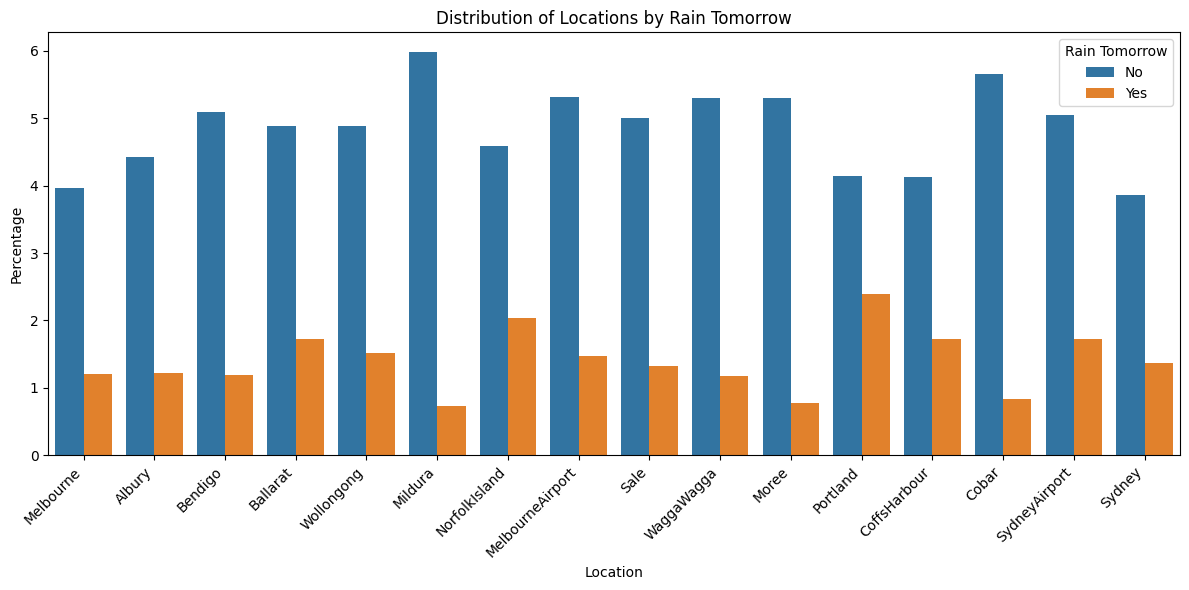

In [ ]:
plt.figure(figsize=(12, 6))  # Adjust figure size

sns.countplot(
    data=df,                     # DataFrame containing the data
    x="Location",                # X-axis variable (locations)
    hue="RainTomorrow",          # Hue variable (rain tomorrow)
    stat="percent"               # Display percentage of counts
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate labels

# Add labels and title for clarity
plt.xlabel('Location')          # X-axis label
plt.ylabel('Percentage')        # Y-axis label
plt.title('Distribution of Locations by Rain Tomorrow')  # Plot title
plt.legend(title='Rain Tomorrow')  # Legend title

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

Ahora que ya tenemos el dataset limpio procederamos a transformar las variables categóricas para poder utilizar el modelo de árbol de decisión.

####Pre-Procesamiento Dataset

In [ ]:
# Reemplazo columna 'Date' por 'Season' basada en Australia
df['Season'] = df['Date'].apply(asignar_estacion)

# Elimino la columna 'Date'
df.drop('Date', axis=1, inplace=True)

In [ ]:
#One hot encoding para variables categoricas
df = pd.get_dummies(df, columns=['Location','Season','WindGustDir','WindDir9am','WindDir3pm'])

### 1er modelo: Árbol de Decisión

In [ ]:
ds_rain = df.copy()
ds_rain.head(7)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,9.5,15.4,2.0,2.8,7.0,63.0,37.0,35.0,60.0,38.0,...,False,False,False,False,False,False,False,True,False,False
1,11.0,14.5,0.6,5.2,4.0,63.0,30.0,35.0,66.0,52.0,...,False,False,False,False,False,False,False,False,False,True
2,8.4,14.1,1.4,2.0,0.8,39.0,17.0,24.0,72.0,58.0,...,False,False,False,False,False,False,False,True,False,False
3,9.1,14.5,0.6,1.8,4.2,19.0,9.0,7.0,87.0,49.0,...,False,False,False,False,False,False,False,False,False,False
4,4.3,15.5,0.0,0.8,8.4,52.0,24.0,30.0,81.0,52.0,...,False,False,False,False,False,False,False,False,False,False
5,5.5,15.4,0.0,2.8,3.0,74.0,31.0,44.0,68.0,48.0,...,True,False,False,False,False,False,False,False,False,False
6,11.5,14.3,0.0,3.0,1.0,57.0,28.0,22.0,73.0,63.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
ds_rain.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Month',
       'Location_Albury', 'Location_Ballarat', 'Location_Bendigo',
       'Location_Cobar', 'Location_CoffsHarbour', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree',
       'Location_NorfolkIsland', 'Location_Portland', 'Location_Sale',
       'Location_Sydney', 'Location_SydneyAirport', 'Location_WaggaWagga',
       'Location_Wollongong', 'Season_Autum', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE',
       'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW',
       'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE',
       'WindGustDir_SSW', 'WindGustDir_SW

In [ ]:
ds_rain['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
ds_rain['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_rain_x = ds_rain.drop(['RainTomorrow'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_rain_y = ds_rain['RainTomorrow'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(ds_rain_x,
                                                    ds_rain_y,
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=7) #semilla

In [ ]:
from sklearn import tree
#Creamos un clasificador con hiperparámetros
tree_model = tree.DecisionTreeClassifier(criterion="gini",
                                         max_depth = 10,
                                         min_samples_split=5)
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

In [ ]:
model.classes_

array([0, 1])

In [ ]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model, max_depth=2,
                                 feature_names=ds_rain_x.columns.to_list(),
                                 filled=True, rounded=True,
                                 class_names=['Not rain tomorrow','Will rain tomorrow']) #model.classes_
plt.show(tree_plot_completo)

In [ ]:
sorted(list(zip(ds_rain_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('Humidity3pm', 0.4680172094196696),
 ('Sunshine', 0.11938076042211933),
 ('WindGustSpeed', 0.08702147577661355),
 ('Pressure3pm', 0.07316731912691728),
 ('Pressure9am', 0.025613201528063022),
 ('Rainfall', 0.023623121976311157),
 ('Humidity9am', 0.022455107878556313),
 ('Evaporation', 0.016957070826368492),
 ('MinTemp', 0.01541642795851133),
 ('Temp9am', 0.015236006322235096),
 ('Temp3pm', 0.015123024562322927),
 ('Cloud3pm', 0.01500681231037135),
 ('WindSpeed3pm', 0.011229459617047565),
 ('MaxTemp', 0.009392839417166496),
 ('WindSpeed9am', 0.007944856399415562),
 ('Location_Portland', 0.007916251205024167),
 ('Cloud9am', 0.007762818058005353),
 ('Month', 0.006512107249929062),
 ('Location_CoffsHarbour', 0.0032849655200047757),
 ('Location_Wollongong', 0.0025118270749442595),
 ('Location_Sydney', 0.0024678789751989283),
 ('WindDir9am_ENE', 0.0021370173658604775),
 ('WindDir9am_WNW', 0.002027846931955344),
 ('Season_Autum', 0.001937786783528464),
 ('Season_Spring', 0.00190025555014352

In [ ]:
#Chequeo métricas luego de realizar predicción con el modelo entrenado
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
ds_resultados1=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados1.head(10)

,test,pred
0,0,0
1,1,1
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


Text(50.722222222222214, 0.5, 'True')

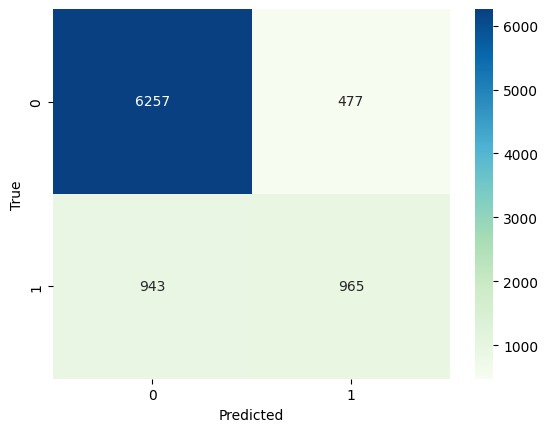

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8356861837537607
Recall: 0.5057651991614256
Precision: 0.6692094313453537
f1 score: 0.5761194029850746


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6734
           1       0.67      0.51      0.58      1908

    accuracy                           0.84      8642
   macro avg       0.77      0.72      0.74      8642
weighted avg       0.82      0.84      0.83      8642



Como un primer árbol base vemos que predice bien los casos de que no lloverá mañana pero tiene un error en detectar los días en que lloverá y los identifica como n, por lo que ajustaremos los parámetros a través de K-Folds CV.

#### Ajuste de hiperparámetros

In [ ]:
ft = ds_rain.columns.to_list()
features = [col for col in ft if col != "RainTomorrow"]
target = "RainTomorrow"

In [ ]:
#Esta proporción fue la misma desde un principio, chequear si hay que tener aprox 50/50
ds_rain[target].value_counts(normalize=True)*100

,proportion
RainTomorrow,
0,77.56845
1,22.43155


In [ ]:
#Separo un set de Evaluacion
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ds_rain[features].values,
                                                    ds_rain[target].values,
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=ds_rain[target].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 34565
# Datos Prueba: 8642
% Positivos Entrenamiento: 22.430
% Positivos Prueba: 22.437


In [ ]:
## K-FOLD CV Random Search para buscar el mejor árbol
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que quiero porbar
n=15

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'min_samples_split': list(range(1,10)),
               'ccp_alpha':np.linspace(0, 1.5, n),
               'max_depth':list(range(1,10))}

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast


In [ ]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 7, 'min_samples_leaf': 9, 'max_depth': 7, 'criterion': 'gini', 'ccp_alpha': 0.0}
0.5644785972255232


In [ ]:
print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))
print(classification_report(y_test,y_pred))


Accuracy: 0.8031705623698218
Recall: 0.5385835095137421
Precision: 0.5517054683270168
f1 score: 0.5450655255415887
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      6750
           1       0.55      0.54      0.55      1892

    accuracy                           0.80      8642
   macro avg       0.71      0.71      0.71      8642
weighted avg       0.80      0.80      0.80      8642



### 2do modelo: Random Forest


In [ ]:
ds_rain_rf = df.copy()
ds_rain_rf.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,9.5,15.4,2.0,2.8,7.0,63.0,37.0,35.0,60.0,38.0,...,False,False,False,False,False,False,False,True,False,False
1,11.0,14.5,0.6,5.2,4.0,63.0,30.0,35.0,66.0,52.0,...,False,False,False,False,False,False,False,False,False,True
2,8.4,14.1,1.4,2.0,0.8,39.0,17.0,24.0,72.0,58.0,...,False,False,False,False,False,False,False,True,False,False
3,9.1,14.5,0.6,1.8,4.2,19.0,9.0,7.0,87.0,49.0,...,False,False,False,False,False,False,False,False,False,False
4,4.3,15.5,0.0,0.8,8.4,52.0,24.0,30.0,81.0,52.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
ds_rain_rf.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Month',
       'Location_Albury', 'Location_Ballarat', 'Location_Bendigo',
       'Location_Cobar', 'Location_CoffsHarbour', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree',
       'Location_NorfolkIsland', 'Location_Portland', 'Location_Sale',
       'Location_Sydney', 'Location_SydneyAirport', 'Location_WaggaWagga',
       'Location_Wollongong', 'Season_Autum', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE',
       'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW',
       'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE',
       'WindGustDir_SSW', 'WindGustDir_SW

In [ ]:
ds_rain_rf['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})
ds_rain_rf['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
ds_rain_rf.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,9.5,15.4,2.0,2.8,7.0,63.0,37.0,35.0,60.0,38.0,...,False,False,False,False,False,False,False,True,False,False
1,11.0,14.5,0.6,5.2,4.0,63.0,30.0,35.0,66.0,52.0,...,False,False,False,False,False,False,False,False,False,True
2,8.4,14.1,1.4,2.0,0.8,39.0,17.0,24.0,72.0,58.0,...,False,False,False,False,False,False,False,True,False,False
3,9.1,14.5,0.6,1.8,4.2,19.0,9.0,7.0,87.0,49.0,...,False,False,False,False,False,False,False,False,False,False
4,4.3,15.5,0.0,0.8,8.4,52.0,24.0,30.0,81.0,52.0,...,False,False,False,False,False,False,False,False,False,False


#### RF

chequeo proporción inicial

In [ ]:
ft = ds_rain_rf.columns.to_list()
features = [col for col in ft if col != "RainTomorrow"]
target = "RainTomorrow"

In [ ]:
ds_rain_rf[target].value_counts(normalize=True)*100

,proportion
RainTomorrow,
0,77.56845
1,22.43155


Implemento división train-test

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_rain_rf_x=ds_rain_rf.drop(['RainTomorrow'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_rain_rf_y = ds_rain_rf['RainTomorrow'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(ds_rain_rf_x,
                                                    ds_rain_rf_y,
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=42) #semilla

In [ ]:
x_train.head(7)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
19301,7.9,15.2,1.4,4.000000,9.200000,56.0,31.0,35.0,53.0,43.0,...,False,False,False,False,False,False,True,False,False,False
28181,-0.1,14.4,0.0,3.000000,11.208897,31.0,11.0,13.0,79.0,36.0,...,False,False,True,False,False,False,False,False,False,False
29638,10.8,28.6,0.0,7.600000,12.029840,35.0,24.0,13.0,26.0,12.0,...,False,False,True,False,False,False,False,False,False,False
39885,7.0,21.5,0.0,5.052409,7.134287,46.0,22.0,17.0,63.0,48.0,...,False,False,False,False,False,False,False,True,False,False
9697,14.7,24.7,2.2,4.703183,6.329227,31.0,11.0,20.0,71.0,64.0,...,False,False,False,False,False,False,False,False,False,True
12899,9.7,13.7,0.4,2.600000,1.800000,56.0,15.0,30.0,82.0,81.0,...,False,False,False,False,False,False,False,False,False,True
31185,17.5,29.5,8.0,4.366320,3.665371,39.0,9.0,11.0,74.0,49.0,...,False,False,True,False,False,False,False,False,False,False


In [ ]:
y_train.head(7)

,RainTomorrow
19301,0
28181,0
29638,0
39885,0
9697,0
12899,1
31185,0


In [ ]:
# Creao un clasificador con hiperparámetros
rfc = RandomForestClassifier(random_state=42,
                             criterion="gini",
                             max_features='sqrt',
                             max_depth=10,
                             n_estimators=100,
                             n_jobs=-1)
# Entreno el modelo
model_rf = rfc.fit(X = x_train, y = y_train)

In [ ]:
# hiperparámetros usados para este RF

print(model_rf.get_params())


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
# Hago una predicción sobre el set de test
y_pred = model_rf.predict(x_test)
# Valores Predichos
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
#Valores Reales
y_test.values

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
# Pruebo verlos juntos en un DataFrame
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head()

,test,pred
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0


##### Matriz de confusión con hiperparámetros sin optimizar

Text(50.722222222222214, 0.5, 'True')

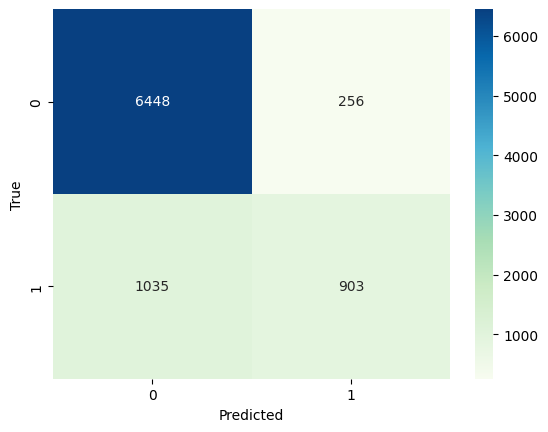

In [ ]:
# Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

# Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))
print("Precision:"+str(precision))

Accuracy: 0.8506132839620458
Recall: 0.46594427244582043
f1 score: 0.5831449790119471
Precision:0.7791199309749784


##### Ploteo: RF

In [ ]:
model_rf.classes_

array([0, 1])

In [ ]:
# plotear el random forest
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Seleccionar un árbol del bosque aleatorio
tree_to_plot = model_rf.estimators_[0]

# Graficar el árbol
plt.figure(figsize=(100, 100))
plot_tree(tree_to_plot, max_depth = 4, feature_names=ds_rain_rf_x.columns.to_list(), class_names=['Not Rain tomorrow', 'Will rain tomorrow'], filled=True, rounded=True)
plt.show()


#### RF aplico -> Optimización de hiperparámetros

Implemento k-fold Cross Validation para optimización de hiperparámetros

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

In [ ]:
ft = ds_rain_rf.columns.to_list()
features = [col for col in ft if col != "RainTomorrow"]
target = "RainTomorrow"

In [ ]:
ds_rain_rf[target].value_counts(normalize=True)*100

,proportion
RainTomorrow,
0,77.56845
1,22.43155


In [ ]:
from sklearn.model_selection import train_test_split

# Separar el conjunto de evaluación
x_train, x_test, y_train, y_test = train_test_split(
    ds_rain_rf[features].values,
    ds_rain_rf[target].values,
    test_size=0.2,            # 20% para el conjunto de prueba
    random_state=42,          # Para reproducir el experimento
    stratify=ds_rain_rf[target].values  # Estratificado para mantener proporciones
)

# Verificar la cantidad de datos en cada conjunto
print(f'# Datos Entrenamiento: {len(x_train)}')
print(f'# Datos Prueba: {len(x_test)}')

# Verificar cómo quedaron balanceados los conjuntos
for split_name, split in zip(['% Positivos Entrenamiento', '% Positivos Prueba'], [y_train, y_test]):
    porcentaje_positivo = pd.Series(split).value_counts(normalize=True)[1] * 100
    print(f'{split_name}: {porcentaje_positivo:.3f}')

# Datos Entrenamiento: 34565
# Datos Prueba: 8642
% Positivos Entrenamiento: 22.430
% Positivos Prueba: 22.437


In [ ]:
base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {"criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 5, 10],
    "min_samples_split": [2, 10, 12, 16],
    "n_estimators": [10, 50, 100, 125],
    "max_depth": [None, 10, 20, 30, 40],
    "max_features": ["sqrt", "log2"],}

#Probamos entrenando con varias métricas

metricas=['accuracy','f1','roc_auc'] #'recall','precision'

folds = 5 #Cantidad de splits para el Cross Validation


kfoldcv = StratifiedKFold(n_splits=folds) #Kfold estratificado

#Random Search Cross Validation
randomcv_multimetrico = RandomizedSearchCV(estimator=base_rf,
                              param_distributions = param_grid,
                              scoring=metricas,
                              cv=kfoldcv,
                              n_iter=84,
                              refit=False,
                              n_jobs=-1,
                              verbose=1)

#Entrenamiento
randomcv_multimetrico_fit = randomcv_multimetrico.fit(X = x_train, y = y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


Obtengo los mejores parámetros

In [ ]:
params_elegidos=randomcv_multimetrico.cv_results_['params'][np.argmax(randomcv_multimetrico.cv_results_['mean_test_accuracy'])]
params_elegidos

creo un clasificador rf con los parámetros elegidos

In [ ]:
#Creamos un clasificador RF
rfc_multimetrica = RandomForestClassifier(criterion=params_elegidos['criterion'],
    min_samples_leaf=params_elegidos['min_samples_leaf'],
    min_samples_split=params_elegidos['min_samples_split'],
    n_estimators=params_elegidos['n_estimators'],
    max_depth=params_elegidos.get('max_depth', None),
    max_features=params_elegidos.get('max_features'),
    bootstrap=True,
    oob_score=True, random_state=42, n_jobs=-1)
#Entrenamos un modelo
model_rfc_multimetrica = rfc_multimetrica.fit(X = x_train, y = y_train)

#Hacemos una predicción
y_pred_model_rfc_multimetrica = model_rfc_multimetrica.predict(x_test)

##### Matriz de confusión con hiperparámetros elegidos por optimización multimétrica

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_model_rfc_multimetrica)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_model_rfc_multimetrica))

In [ ]:
# Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred_model_rfc_multimetrica)
recall=recall_score(y_test,y_pred_model_rfc_multimetrica)
f1=f1_score(y_test,y_pred_model_rfc_multimetrica)
precision=precision_score(y_test,y_pred_model_rfc_multimetrica)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))
print("Precision:"+str(precision))

##### Ploteo: RF con hiperparámetros optimizados

In [ ]:
model_rfc_multimetrica.classes_

In [ ]:
# Seleccionar un árbol del bosque aleatorio
tree_to_plot = model_rfc_multimetrica.estimators_[0]

# Graficar el árbol
plt.figure(figsize=(100, 100))
plot_tree(tree_to_plot, max_depth = 4, feature_names=ds_rain_rf_x.columns.to_list(), class_names=['Not rain tomorrow', 'Will rain tomorrow'], filled=True, rounded=True)
plt.show()


#### RF aplico -> Importancia de atributos + hiperparámetros optimizados

In [ ]:
importancia_atributos = sorted(list(zip(ds_rain_rf_x.columns.to_list(), model_rf.feature_importances_)), key=lambda x: -x[1])
importancia_atributos

Pruebo con los atributos con más impacto en resultados

In [ ]:
# Filtrar atributos con importancia mayor o igual a 0.01
importancia_atributos_filtrados = [(feature, importance) for feature, importance in importancia_atributos if importance >= 0.01]

# Mostrar los atributos filtrados
importancia_atributos_filtrados

In [ ]:
# Obtener solo los nombres de los atributos filtrados
atributos_filtrados_nombres = [feature for feature, importance in importancia_atributos_filtrados]

# Crear un nuevo DataFrame con solo los atributos filtrados
ds_rain_rf_x_filtrado = ds_rain_rf[atributos_filtrados_nombres]

# Mostrar el nuevo DataFrame
ds_rain_rf_x_filtrado.head()

##### Mapa de Calor de Correlación de Atributos de más importancia

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = ds_rain_rf_x_filtrado.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(100, 100))

# Crear el mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .8}, linewidths=0.5)

# Agregar título
plt.title('Mapa de Calor de Correlación de Atributos de más importancia')

# Mostrar el gráfico
plt.show()

In [ ]:
#Creo un dataset con la variable target
ds_rain_rf_y_filtrado = ds_rain_rf['RainTomorrow'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(ds_rain_rf_x_filtrado,
                                                    ds_rain_rf_y_filtrado,
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=42) #semilla

In [ ]:
x_train.head(7)

In [ ]:
y_train.head(7)

In [ ]:
base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {"criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 5, 10],
    "min_samples_split": [2, 10, 12, 16],
    "n_estimators": [10, 50, 100, 125],
    "max_depth": [None, 10, 20, 30, 40],
    "max_features": ["sqrt", "log2"],}

#Probamos entrenando con varias métricas

metricas=['accuracy','f1','roc_auc'] #'recall','precision'

folds = 3 #Cantidad de splits para el Cross Validation


kfoldcv = StratifiedKFold(n_splits=folds) #Kfold estratificado

#Random Search Cross Validation
randomcv_multimetrico_atribs_imp = RandomizedSearchCV(estimator=base_rf,
                              param_distributions = param_grid,
                              scoring=metricas,
                              cv=kfoldcv,
                              n_iter=42,
                              refit=False,
                              n_jobs=-1,
                              verbose=1)

#Entrenamiento
randomcv_multimetrico_atribs_imp_fit = randomcv_multimetrico_atribs_imp.fit(X = x_train, y = y_train)

In [ ]:
# mejores hiperpatametros conseguidos

print(randomcv_multimetrico_fit.best_params_)


In [ ]:
params_elegidos_atribs_imp=randomcv_multimetrico_atribs_imp.cv_results_['params'][np.argmax(randomcv_multimetrico_atribs_imp.cv_results_['mean_test_accuracy'])]
params_elegidos_atribs_imp

In [ ]:
#Creamos un clasificador RF
rfc_multimetrica_atributos_importantes = RandomForestClassifier(criterion=params_elegidos_atribs_imp['criterion'],
    min_samples_leaf=params_elegidos_atribs_imp['min_samples_leaf'],
    min_samples_split=params_elegidos_atribs_imp['min_samples_split'],
    n_estimators=params_elegidos_atribs_imp['n_estimators'],
    max_depth=params_elegidos_atribs_imp.get('max_depth', None),
    max_features=params_elegidos_atribs_imp.get('max_features'),
    bootstrap=True,
    oob_score=True, random_state=42, n_jobs=-1)
#Entrenamos un modelo
model_rfc_multimetrica_atributos_importantes = rfc_multimetrica_atributos_importantes.fit(X = x_train, y = y_train)

#Hacemos una predicción
y_pred_model_rfc_multimetrica_atributos_importantes = model_rfc_multimetrica_atributos_importantes.predict(x_test)

##### Matriz confusión Importancia Atributos + Hiperparámetros optimizados

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_model_rfc_multimetrica_atributos_importantes)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_model_rfc_multimetrica_atributos_importantes))

In [ ]:
# Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred_model_rfc_multimetrica_atributos_importantes)
recall=recall_score(y_test,y_pred_model_rfc_multimetrica_atributos_importantes)
f1=f1_score(y_test,y_pred_model_rfc_multimetrica_atributos_importantes)
precision=precision_score(y_test,y_pred_model_rfc_multimetrica_atributos_importantes)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))
print("Precision:"+str(precision))

##### Ploteo: RF de atributos importantes con hiperparámetros optimizados

In [ ]:
model_rfc_multimetrica_atributos_importantes.classes_

In [ ]:
# Seleccionar un árbol del bosque aleatorio
tree_to_plot = model_rfc_multimetrica_atributos_importantes.estimators_[0]

# Graficar el árbol
plt.figure(figsize=(100, 100))
plot_tree(tree_to_plot, max_depth = 4, feature_names=ds_rain_rf_x_filtrado.columns.to_list(), class_names=['Not rain tomorrow', 'Will rain tomorrow'], filled=True, rounded=True)
plt.show()


#### *Cuadro comparativo modelos Random Forest*

| Modelo                      | Precisión | Accuracy | F1 Score | Recall |
|-----------------------------|-----------|----------|----------|--------|
| Random Forest 1.0 version   |   0.77        |   0.85   |   0.58   |  0.46  |
| Random Forest 2.0 version   |   0.77        |   0.85   |   0.60   |  0.49  |
| Random Forest 3.0 version |    0.77       |     0.85     |     0.62     |   0.52     |

| Modelo                 | Criterion | Min Samples Leaf | Min Samples Split | N Estimators | Max Depth | Max Features | Cross Validation | Folds |
|------------------------|-----------|------------------|-------------------|--------------|-----------|--------------|------------------|-------|
| **Random Forest 1.0**  | gini     | 1                | 2                 | 100          | 10        | sqrt         | None               | -     |
| **Random Forest 2.0**  | entropy   | 1                | 2                 | 100          | 30        | sqrt         | Random Search               | 5     |
| **Random Forest 3.0** | entropy   | 1                | 2                 | 100          | 30        | sqrt         | Random Search               | 3     |

#### *Análisis de Versiones del Clasificador Random Forest*

**Diferencias en los Folds**

En cuanto a los folds seleccionados en las versiones 2.0 y 3.0, la diferencia entre ambas se relaciona con la cantidad de atributos utilizados. En la versión 2.0, se emplearon todos los atributos disponibles, mientras que en la versión 3.0 se trabajó con menos de la mitad, enfocándose únicamente en aquellos atributos considerados "importantes", seleccionados tras analizar el array de importancia de atributos. Esta estrategia buscó concentrar el modelo en las variables más relevantes para la predicción.


**Mejora de Métricas**

Se observa una mejora en las métricas de **F1 Score** y **Recall** al pasar de la versión 1.0 a la versión 3.0. Esta mejora está relacionada con la optimización de los hiperparámetros aplicada en la versión 2.0, así como con la selección de atributos específicos basados en su importancia, combinada con la optimización de hiperparámetros en la versión final.

En cuanto a la **Precisión**, notamos que las versiones iniciales presentan un puntaje equivalente, mientras que la versión final muestra una leve disminución. Esto podría atribuirse a la reducción en el número de atributos utilizados en la última versión. Por otro lado, el **Accuracy** se mantiene constante a pesar de las diferencias entre las versiones.

**Conclusiones sobre la Optimización**

Podemos concluir que la optimización de hiperparámetros mediante **Random Search Cross Validation** tuvo el mayor impacto en las métricas de rendimiento. Aunque la selección de atributos es un factor que puede contribuir a la mejora del modelo, en este caso, el recorte significativo que dejó menos de la mitad de los parámetros originales resultó ser una decisión desfavorable. Un enfoque menos drástico podría haber sido más beneficioso.

Respecto a los puntajes de las métricas, si bien logramos mejorarlos, la desproporción en la cantidad de casos de "Rain Tomorrow" entre las clases "No" y "Yes" limita nuestra capacidad para mejorar aún más estos resultados, dado que no contamos con suficientes datos para la clase positiva.

**Conclusión Final**

En conclusión, consideramos que la mejor versión del clasificador **Random Forest** es la 2.0.


#### *Guardo modelo Random Forest seleccionado*

In [ ]:
# guardo modelo seleccionado de Random Forest
import pickle
with open('model_random_forest_version_2.pkl', 'wb') as file:
    pickle.dump(rfc_multimetrica, file)

### 3er modelo: Ensambles Stacking

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import mean_squared_error, r2_score


#Seleccion variables regresoras y objetivo
X = ds_rain[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
 'Pressure9am', 'Pressure3pm','Cloud9am', 'Cloud3pm','Temp9am', 'Temp3pm', 'RainToday', 'Month', 'Location_Albury', 'Location_Ballarat', 'Location_Bendigo',
 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_NorfolkIsland', 'Location_Portland',
 'Location_Sale', 'Location_Sydney', 'Location_SydneyAirport', 'Location_WaggaWagga', 'Location_Wollongong', 'Season_Autum', 'Season_Spring', 'Season_Summer',
 'Season_Winter', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW',
 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E',
 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
 'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE', 'WindDir3pm_ESE',
 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE', 'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE', 'WindDir3pm_SSW',
 'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW', 'WindDir3pm_WSW']]
y = ds_rain['RainTomorrow']

#traine y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

#modelos base
knn_clas =KNeighborsClassifier (n_neighbors=1)
rf_clas = RandomForestClassifier(n_estimators=100, random_state=13)
xgb_reg = XGBRFClassifier(random_state=13)

#meta-modelo
meta_model = RandomForestClassifier(n_estimators=100, random_state=13)

#se hace el ensamble
stacking_classifier = StackingClassifier(
    estimators=[('knn', knn_clas), ('rf', rf_clas), ('xgb', xgb_reg)],
    final_estimator= meta_model
)

#training
stacking_classifier.fit(X_train, y_train)

#test
y_pred = stacking_classifier.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)


En tests:


In [ ]:

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))



Accuracy: 0.8031705623698218
F1 Score: 0.5450655255415887
Precision: 0.5517054683270168
Recall: 0.5385835095137421

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      6750
           1       0.55      0.54      0.55      1892

    accuracy                           0.80      8642
   macro avg       0.71      0.71      0.71      8642
weighted avg       0.80      0.80      0.80      8642



### Cuadro de resultados

| Modelo                 | Precisión| Accuracy | F1 Score | Recall |
|------------------------|----------|----------|----------|--------|
| Árbol de Decisión      |   0.55       |    0.80      |    0.55      |   0.54     |
| Random Forest          |      0.77    |     0.85     |    0.60      |    0.49    |
| Ensemble Stacking      |     0.55     |  0.80        |   0.54       |  0.53      |

*Random Forest: Se utiliza la versión 2.0

### Conclusión: *¿Qué modelo elegirían para predecir si lloverá o no al día siguiente?*

Entre todos los modelos de classifiers desarrollados el que mejores resultados obtuvo fue la versión 2.0 de Random Forest